# Operations on Word Vectors
- Because word embedddings are very computationally expensive to train, most ML practitioners will load a pre-trained set of embeddings.
- We'll try to load, measure similarity b/w and modiying pre-trained embeddings.
- We'll be able to : 
    - Explain how word embeddings capture relationships b/w words.
    - Load pre-tained word vectors
    - Measure similarity b/w word vectors using cosine similarity
    - Use word embeddings to solve word analogy problems such as Man is to Women as kinf is to ___.

# Packages

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing import sequence

import urllib.request
import collections
import os
import zipfile

import numpy as np
import tensorflow as tf

# 1. Load the Word Vectors
- We'll use 50-dimensional GloVe vectors to represent words.

In [8]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
            
    return words, word_to_vec_map

In [ ]:
words, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

- We've loaded : 
    - words : set of words in the vocabulary
    - word_to_vec_map : dictionary mapping words to their GloVe vector representation

# 2. Embedding Vectors vs One-hot Vectors
- The one-hot vectors don't do a good job capturing the level of similarity b/w words. This is because every one-hot vector has the same Euclidean distance from any other one-hot vector.
- Embedding vectors, such as GloVe vectors, provide much more useful information about the meaning of individual words. 

# 3. Cosine similarity 
- To measure the similarity b/w 2 words, we need a way to measure the degree of similarity b/w 2 embedding vectors for the 2 words. Given 2 vectors u and v, cosine similarity is defined as follows : 
     - 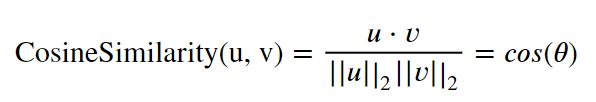
- u.v is the dot product or inner product of 2 vectors
- ||u||_2 is the norm or lenght of the vector u
- Theta is the angle b/w u and v
- The cosine similarity depends on the angle b/w u and v.
    - If u and v are very similar, their cosine similarity will be close to 1.
    - If they are dissimilar, the cosine similarity will take a smaller value.
    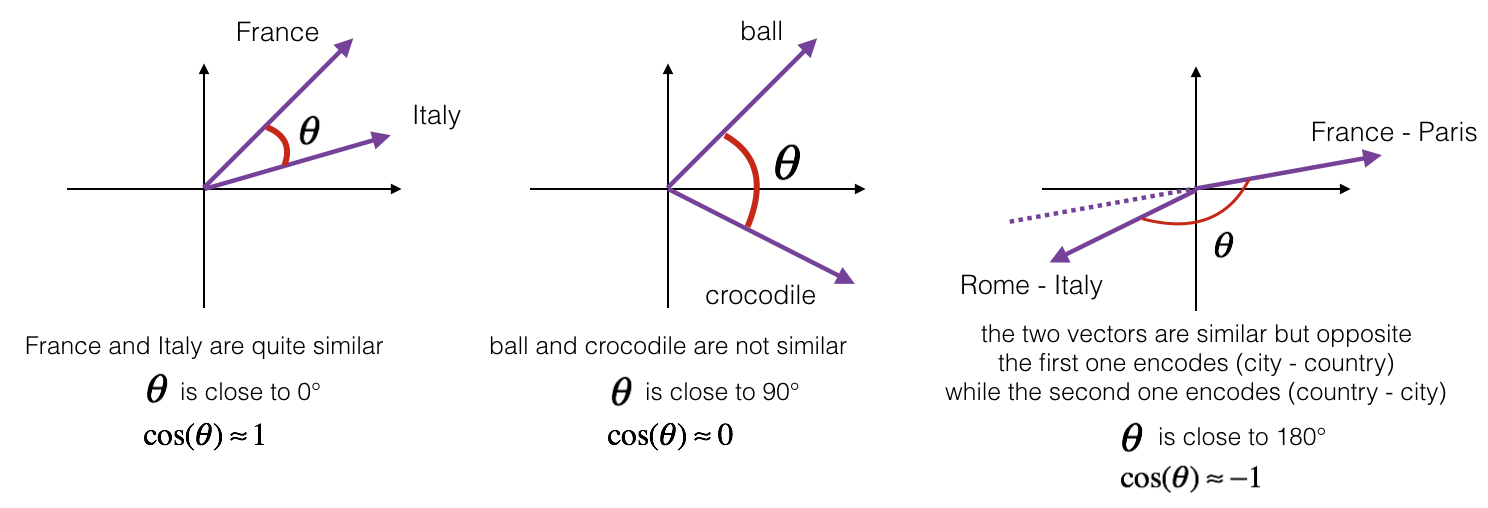

In [6]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similarity between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    
    # Special case. Consider the case u = [0, 0], v=[0, 0]
    if np.all(u == v):
        return 1
    
    ### START CODE HERE ###
    # Compute the dot product between u and v (≈1 line)
    dot = np.dot(u, v) 
    # Compute the L2 norm of u (≈1 line)
    norm_u = np.sqrt(np.sum(np.square(u)))
    
    # Compute the L2 norm of v (≈1 line)
    norm_v = np.sqrt(np.sum(np.square(v)))
    
    # Avoid division by 0
    if np.isclose(norm_u * norm_v, 0, atol=1e-32):
        return 0
    
    # Compute the cosine similarity defined by formula (1) (≈1 line)
    cosine_similarity = dot/(norm_u*norm_v)
    ### END CODE HERE ###
    
    return cosine_similarity

# 4. Word Analogy Task
- In the word analoy task, complete the sentence
    - 'a is to b as c is to ___'
- An examples is : 
    - man is to women as king is to queen
- We're trying to find a word d, such that the associated word vector e_a, e_b, e_c, e_d are in the following mannger
    - e_b-e_a approximate e_d-e_c

In [10]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    """
    Performs the word analogy task as explained above: a is to b as c is to ____. 
    
    Arguments:
    word_a -- a word, string
    word_b -- a word, string
    word_c -- a word, string
    word_to_vec_map -- dictionary that maps words to their corresponding vectors. 
    
    Returns:
    best_word --  the word such that v_b - v_a is close to v_best_word - v_c, as measured by cosine similarity
    """
    
    # convert words to lowercase
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    
    ### START CODE HERE ###
    # Get the word embeddings e_a, e_b and e_c (≈1-3 lines)
    e_a, e_b, e_c = word_to_vec_map[word_a], word_to_vec_map[word_b], word_to_vec_map[word_c]
    ### END CODE HERE ###
    
    words = word_to_vec_map.keys()
    max_cosine_sim = -100              # Initialize max_cosine_sim to a large negative number
    best_word = None                   # Initialize best_word with None, it will help keep track of the word to output
    
    # loop over the whole word vector set
    for w in words:   
        # to avoid best_word being one the input words, skip the input word_c
        # skip word_c from query
        if w == word_c:
            continue
        
        ### START CODE HERE ###
        # Compute cosine similarity between the vector (e_b - e_a) and the vector ((w's vector representation) - e_c)  (≈1 line)
        cosine_sim = cosine_similarity(np.subtract(e_b, e_a), np.subtract(word_to_vec_map[w], e_c))
        
        # If the cosine_sim is more than the max_cosine_sim seen so far,
            # then: set the new max_cosine_sim to the current cosine_sim and the best_word to the current word (≈3 lines)
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
        ### END CODE HERE ###
        
    return best_word